In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=1000) # just read first 1000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(14795, 4)

In [8]:
# looking for bad data
bad_data = 0
for i in range(len(data)):
    if(0.0 in data[i]):
        bad_data += 1

In [9]:
(bad_data, len(data))

(439, 14795)

In [10]:
# checking distribution of data
(data[:][1].mean(), data[:][1].std()) # eta

(344.6350920188037, 387.5184029169282)

In [11]:
# regularize
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim = 12
final_dim = 4
latent_dim = 2
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim, activation='relu')(x)
h2 = Dense(final_dim, activation='relu')(h1)
z_mean = Dense(latent_dim)(h2)
z_log_sigma = Dense(latent_dim)(h2)

In [16]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [17]:
# decoder
decoder_h2 = Dense(final_dim, activation='relu')
decoder_h1 = Dense(inter_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')

h2_decoded = decoder_h2(z)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [18]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [19]:
def vae_loss(x, y):
    xent_loss = metrics.mse(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [20]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           60          input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            52          dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            10          dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):]
batch_size = 100
epochs = 100

In [23]:
x_train.shape

(11836, 4)

In [24]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val))

Train on 11836 samples, validate on 2959 samples
Epoch 1/100
11836/11836 [==============================] - 1s 109us/step - loss: 0.1318 - val_loss: 0.0948
Epoch 2/100
11836/11836 [==============================] - 1s 52us/step - loss: 0.0767 - val_loss: 0.0652
Epoch 3/100
11836/11836 [==============================] - 1s 51us/step - loss: 0.0587 - val_loss: 0.0551
Epoch 4/100
11836/11836 [==============================] - 1s 49us/step - loss: 0.0527 - val_loss: 0.0514
Epoch 5/100
11836/11836 [==============================] - 1s 52us/step - loss: 0.0505 - val_loss: 0.0503
Epoch 6/100
11836/11836 [==============================] - 1s 51us/step - loss: 0.0498 - val_loss: 0.0499
Epoch 7/100
11836/11836 [==============================] - 1s 50us/step - loss: 0.0496 - val_loss: 0.0497
Epoch 8/100
11836/11836 [==============================] - 1s 50us/step - loss: 0.0494 - val_loss: 0.0496
Epoch 9/100
11836/11836 [==============================] - 1s 50us/step - loss: 0.0493 - val_loss: 0.0

11836/11836 [==============================] - 1s 51us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 78/100
11836/11836 [==============================] - 1s 51us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 79/100
11836/11836 [==============================] - 1s 50us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 80/100
11836/11836 [==============================] - 1s 54us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 81/100
11836/11836 [==============================] - 1s 53us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 82/100
11836/11836 [==============================] - 1s 54us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 83/100
11836/11836 [==============================] - 1s 52us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 84/100
11836/11836 [==============================] - 1s 51us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 85/100
11836/11836 [==============================] - 1s 55us/step - loss: 0.0489 - val_loss: 0.0491
Epoch 86/100
11836/11836 [========================

# Visualization

In [25]:
import matplotlib.pyplot as plt

In [26]:
predictions = vae.predict(x_val)

In [27]:
predictions

array([[0.06814661, 0.50394183, 0.49720648, 0.03695662],
       [0.0646138 , 0.50798   , 0.4972315 , 0.03530638],
       [0.06618094, 0.5036666 , 0.4970234 , 0.03426499],
       ...,
       [0.0666014 , 0.50398874, 0.49478635, 0.03412097],
       [0.06977252, 0.50345194, 0.49686578, 0.04055461],
       [0.06767675, 0.5021176 , 0.49312213, 0.03601076]], dtype=float32)

In [28]:
distr = (x_val - predictions) / x_val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [29]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [30]:
pT = [row[0] for row in x_val]
eta = [row[1] for row in x_val]
phi = [row[2] for row in x_val]
mass = [row[3] for row in x_val]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([   0., 2558.,  401.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <a list of 29 Patch objects>)

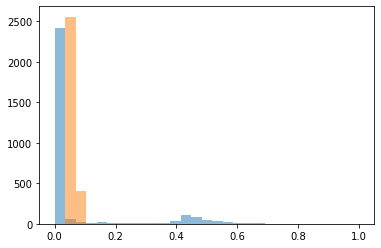

In [81]:
bins = np.linspace(0, 1, 30)
plt.hist(pT, bins=bins,alpha=0.5)
plt.hist(pT_pred, bins=bins,alpha=0.5)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 2959.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <a list of 29 Patch objects>)

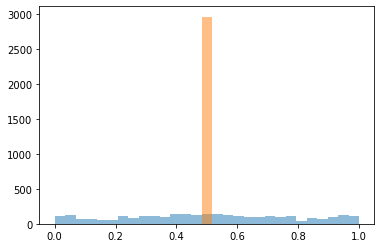

In [68]:
plt.hist(eta, bins=bins,alpha=0.5)
plt.hist(eta_pred, bins=bins,alpha=0.5)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 2959.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <a list of 29 Patch objects>)

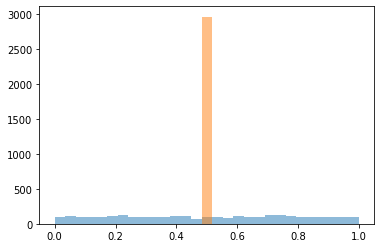

In [69]:
plt.hist(phi, bins=bins,alpha=0.5)
plt.hist(phi_pred, bins=bins,alpha=0.5)

(array([1058., 1901.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <a list of 29 Patch objects>)

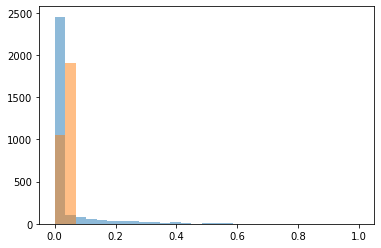

In [70]:
plt.hist(mass, bins=bins,alpha=0.5)
plt.hist(mass_pred, bins=bins,alpha=0.5)

In [71]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

In [76]:
bins = np.linspace(-1, 1, 30)

(array([  3.,   3.,   4.,   4.,   2.,   3.,   3.,   6.,   1.,   3.,   8.,
          8.,   5.,   6.,   3.,   6.,   6.,   2.,   3.,   6.,   5.,   7.,
         13.,  18.,   8.,  29., 249., 132.,   0.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

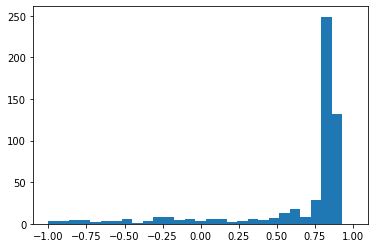

In [77]:
plt.hist(d_pT, bins=bins)

(array([ 11.,  30.,  29.,  40.,  38.,  54.,  49.,  42.,  57.,  58.,  91.,
         95.,  94., 111., 143., 168., 155., 154., 205., 213., 205., 300.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

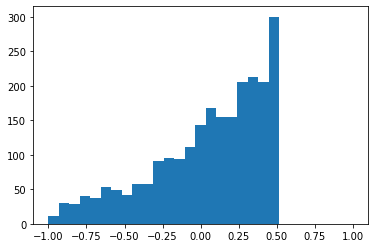

In [78]:
plt.hist(d_eta, bins=bins)

(array([ 18.,  34.,  26.,  33.,  42.,  35.,  40.,  44.,  58.,  50.,  57.,
         73.,  85.,  63., 100., 113., 118., 161., 203., 267., 290., 295.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

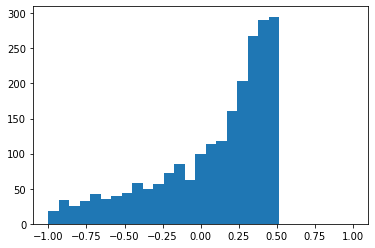

In [79]:
plt.hist(d_phi, bins=bins)